<h1><center>THE BATTLE OF THE NEIGHBOURHOODS</h1>

<H2><center>Explore the cuisine distribution across the main districts of Riyadh

<h4>Importing and Installing All Required Project Modules</h4>

In [596]:
#!pip install pandas
#!pip install requests
#!pip install bs4
#!pip install plotly
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib.request
import re
import string
import csv
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Riyadh_Food")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Webscraping Wikepedia to get the Districts Data

In [597]:
#SCRAPE THE PAGE
url = "https://en.wikipedia.org/wiki/Riyadh"
html_data  = requests.get(url).text
html = urllib.request.urlopen(url)

#PARSE THE PAGE
htmlParse = BeautifulSoup(html, 'html.parser')
htmlParse.find_all("b", limit=18)
raw = []
for uls in htmlParse.findAll('li'):
    lis = uls.findAll('b')
    for li in lis:
        raw.append(li.text)

#CLEANSE THE DATAFRAME
DISTRICTS = raw[0:17]
DISTRICTS = [''.join(c for c in s if c not in string.punctuation) for s in DISTRICTS]
df1=pd.DataFrame(DISTRICTS, columns =['District'])
df1["District"]= df1["District"].str.replace("AlOlayya\s+Sulaymaniyyah", "AlOlayya", regex=True)

#DATACHECK
df1.head(20)

,District
0,AlBatha
1,AlOlayya
2,Nemar
3,Irqah
4,Diplomatic Quarter
5,AlShemaysi
6,AlMaathar
7,AlHair
8,AlAziziyyah
9,AlMalaz


<h4>Importing Coordinates from CSV</h4>

In [598]:
gdrive_file_id = '1_LGj9_C8GmykhD3d9Ak4K6xU4YmJj9la'
df2 = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_file_id}&export=download', encoding='ISO-8859-1')
df2.head(20)

,District,Latitude,Longitude
0,AlShemaysi,24.625879,46.700582
1,Irqah,24.687439,46.589754
2,AlMaathar,24.667999,46.676242
3,AlOlayya,24.696350,46.683420
4,AlAziziyyah,24.589674,46.768103
5,AlMalaz,24.665267,46.733832
6,AlSelayy,24.654501,46.839976
7,Nemar,24.576609,46.689183
8,AlNeseem,24.732367,46.834095
9,AlShifa,24.565623,46.698272


<h4>Merging DataFrames</h4>

In [599]:
dataset=(pd.merge(df1, df2, on='District'))
dataset.head(30)

,District,Latitude,Longitude
0,AlBatha,24.621806,46.719944
1,AlOlayya,24.696350,46.683420
2,Nemar,24.576609,46.689183
3,Irqah,24.687439,46.589754
4,Diplomatic Quarter,24.680288,46.621986
5,AlShemaysi,24.625879,46.700582
6,AlMaathar,24.667999,46.676242
7,AlHair,24.406464,46.842597
8,AlAziziyyah,24.589674,46.768103
9,AlMalaz,24.665267,46.733832


<h4>Building District Clusters for Riyadh</h4>

<h5>Coordinates of Riyadh</h5>

In [600]:
address = 'Riyadh'

geolocator = Nominatim(user_agent="Riyadh")
location = geolocator.geocode(address)
latr = location.latitude
longr = location.longitude
print('Coordinates of Riyadh {}, {}.'.format(latr, longr))

Coordinates of Riyadh 24.638916, 46.7160104.


<h5>Visualization the Districts of Riyadh</h5>

In [601]:
# create map of Riyadh using latitude and longitude 
riyadh_map = folium.Map(location=[latr, longr], zoom_start=11)

# add markers to the map

for lat, lng, label in zip(dataset[' Latitude'].values, dataset[' Longitude'].values, dataset['District'].values):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riyadh_map)
riyadh_map

<h5>Integrating with Foursquare API</h5?

In [602]:
CLIENT_ID = 'IY3PACWRCRB40NBDMGEETGHJEOHRAH1M0GRPPSITPA0NFFMC' # your Foursquare ID
CLIENT_SECRET = 'HDHRHGA250KY42NS3R32OUUFAAAIDUHLPBV11J1YVZLMBOWH' # your Foursquare Secret
VERSION = '20180604'
TOKEN = 'JREMY24SRM2G1U2NKVYIEVI2DJY4XKPES1MRNJJ0VCXZDZ52'
LIMIT = 30

In [603]:
dataset.loc[0, 'District']
neighborhood_latitude = dataset.loc[0, ' Latitude'] # neighborhood latitude value
neighborhood_longitude = dataset.loc[0, ' Longitude'] # neighborhood longitude value
neighborhood_name = dataset.loc[0, 'District'] # neighborhood name

LIMIT = 15
radius = 5000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    TOKEN,
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=IY3PACWRCRB40NBDMGEETGHJEOHRAH1M0GRPPSITPA0NFFMC&client_secret=HDHRHGA250KY42NS3R32OUUFAAAIDUHLPBV11J1YVZLMBOWH&oauth_token=JREMY24SRM2G1U2NKVYIEVI2DJY4XKPES1MRNJJ0VCXZDZ52&v=20180604&ll=24.621806,46.719944&radius=5000&limit=15'

In [604]:
results = requests.get(url).json()

In [605]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [606]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Al Thomairi Old Market (سوق الثميري القديم),Fabric Shop,24.630015,46.713228
1,Al Zal Bazaar (سوق الزل التراثي),Flea Market,24.629318,46.712572
2,محامص ومطاحن السوادي,Snack Place,24.627147,46.709167
3,شيخ البلد,Middle Eastern Restaurant,24.618268,46.724667
4,Masmak Fortress (قصر المصمك),Castle,24.631262,46.713420


<h4>Data Exploration

In [607]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&oauth_token={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            TOKEN,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [608]:
Riyadh_venues = getNearbyVenues(names=dataset['District'],
                                   latitudes=dataset[' Latitude'],
                                   longitudes=dataset[' Longitude']
                                  )

AlBatha
AlOlayya
Nemar
Irqah
Diplomatic Quarter
AlShemaysi
AlMaathar
AlHair
AlAziziyyah
AlMalaz
AlShifa
AlUrayja
AlShemal
AlRawdhah
AlSelayy
King Abdullah Financial District


<h4>Data Cleansing

In [609]:
#GET RESTAURANT DATA ONLY
Riyadh_Venues_only_restaurant = Riyadh_venues[Riyadh_venues['Venue Category'].str.contains(' Restaurant')].reset_index(drop=True)
Riyadh_Venues_only_restaurant.index = np.arange(1, len(Riyadh_Venues_only_restaurant )+1)
print (Riyadh_Venues_only_restaurant['Venue Category'].value_counts())

Middle Eastern Restaurant      58
Fast Food Restaurant           29
Falafel Restaurant              9
Turkish Restaurant              6
French Restaurant               6
American Restaurant             5
Afghan Restaurant               5
Italian Restaurant              4
Kebab Restaurant                4
Japanese Restaurant             4
Sushi Restaurant                3
Eastern European Restaurant     3
Seafood Restaurant              3
Yemeni Restaurant               1
Mexican Restaurant              1
Pakistani Restaurant            1
Asian Restaurant                1
Armenian Restaurant             1
Indian Restaurant               1
Arepa Restaurant                1
Persian Restaurant              1
Name: Venue Category, dtype: int64


In [610]:
# create a dataframe of top 10 categories
Riyadh_Venues_Top10 = Riyadh_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Riyadh_Venues_Top10 =Riyadh_Venues_Top10.reset_index()
Riyadh_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Riyadh_Venues_Top10

,Venue_Category,Frequency
0,Middle Eastern Restaurant,58
1,Fast Food Restaurant,29
2,Falafel Restaurant,9
3,Turkish Restaurant,6
4,French Restaurant,6
5,American Restaurant,5
6,Afghan Restaurant,5
7,Italian Restaurant,4
8,Kebab Restaurant,4
9,Japanese Restaurant,4


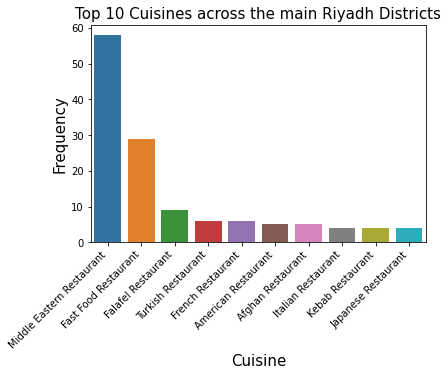

<Figure size 1296x504 with 0 Axes>

In [636]:
s=sns.barplot(x="Venue_Category", y="Frequency", data=Riyadh_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Top 10 Cuisines across the main Riyadh Districts', fontsize=15)
plt.xlabel("Cuisine", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [661]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Riyadh_Venues_only_restaurant.shape)
Riyadh_Venues_only_restaurant.head()

Shape of the Data-Frame with Venue Category only Restaurant:  (147, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,AlBatha,24.621806,46.719944,شيخ البلد,24.618268,46.724667,Middle Eastern Restaurant
2,AlBatha,24.621806,46.719944,AL TYSEER (مطاعم التيسير),24.618318,46.726412,Middle Eastern Restaurant
3,AlBatha,24.621806,46.719944,مطعم الرياض رؤوس مندي و مقادم,24.630071,46.719779,Middle Eastern Restaurant
4,AlBatha,24.621806,46.719944,مشويات الاطلال,24.638109,46.711128,Middle Eastern Restaurant
5,AlBatha,24.621806,46.719944,Golden Saj Restaurant (مطعم الصاج الذهبي),24.644636,46.700784,Middle Eastern Restaurant


In [662]:
Riyadh_Venues_restaurant = Riyadh_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [663]:
Riyadh_Venues_restaurant

Neighborhood
AlAziziyyah                         22
AlBatha                             14
AlMaathar                            3
AlMalaz                              2
AlOlayya                             5
AlRawdhah                            6
AlSelayy                            20
AlShemal                             5
AlShemaysi                           6
AlShifa                             15
AlUrayja                            12
Diplomatic Quarter                   6
Irqah                                8
King Abdullah Financial District     7
Nemar                               16
Name: Venue Category, dtype: int64

In [664]:
Riyadh_Venues_restaurant_df  = Riyadh_Venues_restaurant.to_frame().reset_index()
Riyadh_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
Riyadh_Venues_restaurant_df.index = np.arange(1, len(Riyadh_Venues_restaurant_df)+1)
list_rest_no =Riyadh_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =Riyadh_Venues_restaurant_df['Neighborhood'].to_list()

In [665]:
# one hot encoding
Riyadh_onehot = pd.get_dummies(Riyadh_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Riyadh_onehot['Neighborhood'] = Riyadh_Venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Riyadh_onehot.columns[-1]] + list(Riyadh_onehot.columns[:-1])
Riyadh_onehot = Riyadh_onehot[fixed_columns]

Riyadh_grouped = Riyadh_onehot.groupby('Neighborhood').mean().reset_index()
Riyadh_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pakistani Restaurant,Persian Restaurant,Seafood Restaurant,Sushi Restaurant,Turkish Restaurant,Yemeni Restaurant
0,AlAziziyyah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.136364,0.272727,0.000000,0.00,0.000000,0.000000,0.090909,0.000,0.272727,0.000000,0.000000,0.045455,0.000000,0.181818,0.0000
1,AlBatha,0.071429,0.000000,0.071429,0.0,0.000000,0.000000,0.071429,0.071429,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
2,AlMaathar,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.333333,0.00,0.000000,0.000000,0.000000,0.000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
3,AlMalaz,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
4,AlOlayya,0.000000,0.000000,0.000000,0.2,0.000000,0.200000,0.000000,0.000000,0.200000,0.00,0.200000,0.000000,0.000000,0.000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
5,AlRawdhah,0.000000,0.000000,0.000000,0.0,0.166667,0.166667,0.166667,0.000000,0.000000,0.00,0.000000,0.166667,0.000000,0.000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
6,AlSelayy,0.050000,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,0.350000,0.000000,0.05,0.000000,0.000000,0.000000,0.000,0.400000,0.000000,0.000000,0.000000,0.000000,0.050000,0.0000
7,AlShemal,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.400000,0.000000,0.000,0.400000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0000
8,AlShemaysi,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.166667,0.000000,0.0000
9,AlShifa,0.066667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.400000,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.466667,0.066667,0.000000,0.000000,0.000000,0.000000,0.0000


In [666]:
num_top_venues = 10

for hood in Riyadh_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Riyadh_grouped[Riyadh_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AlAziziyyah----
                       venue  freq
0       Fast Food Restaurant  0.27
1  Middle Eastern Restaurant  0.27
2         Turkish Restaurant  0.18
3         Falafel Restaurant  0.14
4           Kebab Restaurant  0.09
5         Seafood Restaurant  0.05
6          Afghan Restaurant  0.00
7           Sushi Restaurant  0.00
8         Persian Restaurant  0.00
9       Pakistani Restaurant  0.00


----AlBatha----
                       venue  freq
0  Middle Eastern Restaurant  0.71
1          Afghan Restaurant  0.07
2           Arepa Restaurant  0.07
3         Falafel Restaurant  0.07
4       Fast Food Restaurant  0.07
5           Kebab Restaurant  0.00
6         Turkish Restaurant  0.00
7           Sushi Restaurant  0.00
8         Seafood Restaurant  0.00
9         Persian Restaurant  0.00


----AlMaathar----
                         venue  freq
0  Eastern European Restaurant  0.33
1            French Restaurant  0.33
2    Middle Eastern Restaurant  0.33
3            Afghan Rest

In [667]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Riyadh_grouped['Neighborhood']

for ind in np.arange(Riyadh_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Riyadh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(23)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AlAziziyyah,Fast Food Restaurant,Middle Eastern Restaurant,Turkish Restaurant,Falafel Restaurant,Kebab Restaurant,Seafood Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
1,AlBatha,Middle Eastern Restaurant,Afghan Restaurant,Arepa Restaurant,Falafel Restaurant,Fast Food Restaurant,Indian Restaurant,American Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
2,AlMaathar,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Falafel Restaurant
3,AlMalaz,Middle Eastern Restaurant,Falafel Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant,Fast Food Restaurant
4,AlOlayya,Italian Restaurant,Armenian Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Falafel Restaurant
5,AlRawdhah,Middle Eastern Restaurant,Asian Restaurant,Eastern European Restaurant,Falafel Restaurant,Japanese Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
6,AlSelayy,Middle Eastern Restaurant,Fast Food Restaurant,Falafel Restaurant,Afghan Restaurant,Turkish Restaurant,Indian Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
7,AlShemal,Middle Eastern Restaurant,Japanese Restaurant,Seafood Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
8,AlShemaysi,Middle Eastern Restaurant,Afghan Restaurant,Sushi Restaurant,Fast Food Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
9,AlShifa,Middle Eastern Restaurant,Fast Food Restaurant,Afghan Restaurant,Pakistani Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant


<h5>Data Clustering using k-means

In [668]:
# set number of clusters (I choose 5)
kclusters = 6

Riyadh_grouped_clustering = Riyadh_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Riyadh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 1, 0, 3, 0, 2, 5, 2, 1, 5], dtype=int32)

In [669]:
Riyadh_merged = dataset
Riyadh_merged.head(20)

,Neighborhood,Latitude,Longitude
0,AlBatha,24.621806,46.719944
1,AlOlayya,24.696350,46.683420
2,Nemar,24.576609,46.689183
3,Irqah,24.687439,46.589754
4,Diplomatic Quarter,24.680288,46.621986
5,AlShemaysi,24.625879,46.700582
6,AlMaathar,24.667999,46.676242
7,AlHair,24.406464,46.842597
8,AlAziziyyah,24.589674,46.768103
9,AlMalaz,24.665267,46.733832


In [670]:
neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AlAziziyyah,Fast Food Restaurant,Middle Eastern Restaurant,Turkish Restaurant,Falafel Restaurant,Kebab Restaurant,Seafood Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
1,AlBatha,Middle Eastern Restaurant,Afghan Restaurant,Arepa Restaurant,Falafel Restaurant,Fast Food Restaurant,Indian Restaurant,American Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
2,AlMaathar,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Falafel Restaurant
3,AlMalaz,Middle Eastern Restaurant,Falafel Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant,Fast Food Restaurant
4,AlOlayya,Italian Restaurant,Armenian Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Falafel Restaurant
5,AlRawdhah,Middle Eastern Restaurant,Asian Restaurant,Eastern European Restaurant,Falafel Restaurant,Japanese Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
6,AlSelayy,Middle Eastern Restaurant,Fast Food Restaurant,Falafel Restaurant,Afghan Restaurant,Turkish Restaurant,Indian Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
7,AlShemal,Middle Eastern Restaurant,Japanese Restaurant,Seafood Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
8,AlShemaysi,Middle Eastern Restaurant,Afghan Restaurant,Sushi Restaurant,Fast Food Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
9,AlShifa,Middle Eastern Restaurant,Fast Food Restaurant,Afghan Restaurant,Pakistani Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant


<h6>Lost 1 district (AlHair) which doesn't have any restaurants around a 3km radius from the center.

In [671]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted
neighborhoods_venues_sorted_w_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted_w_clusters.head(13)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,AlAziziyyah,Fast Food Restaurant,Middle Eastern Restaurant,Turkish Restaurant,Falafel Restaurant,Kebab Restaurant,Seafood Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
1,1,AlBatha,Middle Eastern Restaurant,Afghan Restaurant,Arepa Restaurant,Falafel Restaurant,Fast Food Restaurant,Indian Restaurant,American Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
2,0,AlMaathar,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Falafel Restaurant
3,3,AlMalaz,Middle Eastern Restaurant,Falafel Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant,Fast Food Restaurant
4,0,AlOlayya,Italian Restaurant,Armenian Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Falafel Restaurant
5,2,AlRawdhah,Middle Eastern Restaurant,Asian Restaurant,Eastern European Restaurant,Falafel Restaurant,Japanese Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
6,5,AlSelayy,Middle Eastern Restaurant,Fast Food Restaurant,Falafel Restaurant,Afghan Restaurant,Turkish Restaurant,Indian Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
7,2,AlShemal,Middle Eastern Restaurant,Japanese Restaurant,Seafood Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
8,1,AlShemaysi,Middle Eastern Restaurant,Afghan Restaurant,Sushi Restaurant,Fast Food Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
9,5,AlShifa,Middle Eastern Restaurant,Fast Food Restaurant,Afghan Restaurant,Pakistani Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant


In [672]:
Riyadh_merged.rename(columns={'District':'Neighborhood'}, inplace=True)

Riyadh_merged = Riyadh_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Riyadh_merged = Riyadh_merged.dropna()
Riyadh_merged.head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AlBatha,24.621806,46.719944,1.0,Middle Eastern Restaurant,Afghan Restaurant,Arepa Restaurant,Falafel Restaurant,Fast Food Restaurant,Indian Restaurant,American Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
1,AlOlayya,24.696350,46.683420,0.0,Italian Restaurant,Armenian Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Falafel Restaurant
2,Nemar,24.576609,46.689183,5.0,Middle Eastern Restaurant,Fast Food Restaurant,American Restaurant,Yemeni Restaurant,Falafel Restaurant,Afghan Restaurant,Pakistani Restaurant,Mexican Restaurant,Kebab Restaurant,Japanese Restaurant
3,Irqah,24.687439,46.589754,4.0,Middle Eastern Restaurant,Italian Restaurant,French Restaurant,Mexican Restaurant,Fast Food Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
4,Diplomatic Quarter,24.680288,46.621986,1.0,Middle Eastern Restaurant,French Restaurant,Sushi Restaurant,Kebab Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
5,AlShemaysi,24.625879,46.700582,1.0,Middle Eastern Restaurant,Afghan Restaurant,Sushi Restaurant,Fast Food Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
6,AlMaathar,24.667999,46.676242,0.0,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Falafel Restaurant
8,AlAziziyyah,24.589674,46.768103,5.0,Fast Food Restaurant,Middle Eastern Restaurant,Turkish Restaurant,Falafel Restaurant,Kebab Restaurant,Seafood Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
9,AlMalaz,24.665267,46.733832,3.0,Middle Eastern Restaurant,Falafel Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant,Fast Food Restaurant
10,AlShifa,24.565623,46.698272,5.0,Middle Eastern Restaurant,Fast Food Restaurant,Afghan Restaurant,Pakistani Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant


<h4>Data Visualization

<h5>Cuisine Breakdown by Districts

<AxesSubplot:title={'center':'Cuisines By Neighborhood'}, ylabel='Neighborhood'>

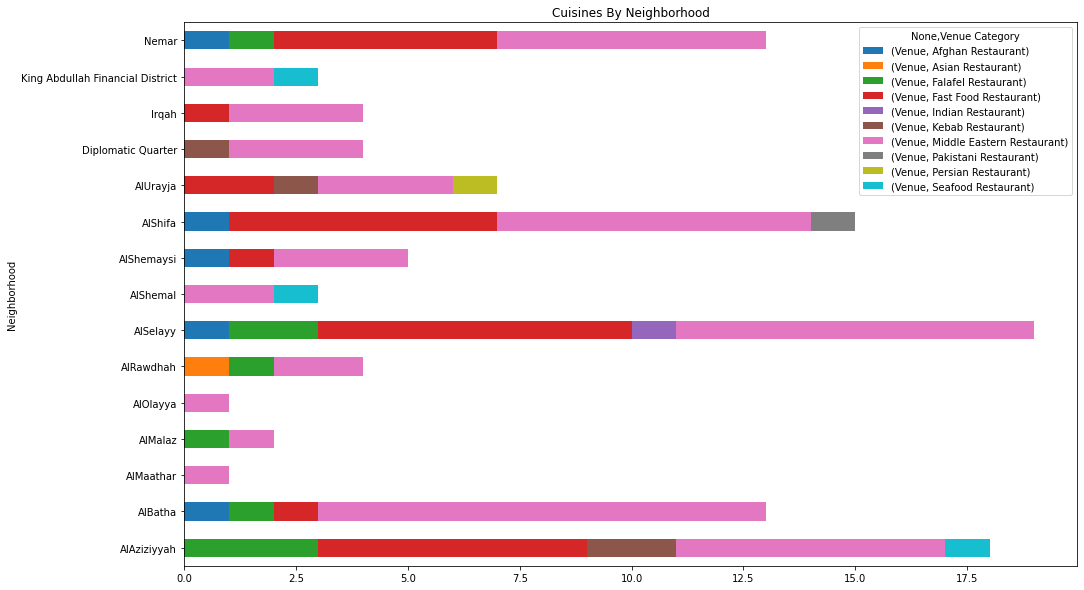

In [673]:
RUH_VEN_IN_10=Riyadh_Venues_only_restaurant[
(Riyadh_Venues_only_restaurant['Venue Category']=='Middle Eastern Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Fast Food Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Falafel Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Asian Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Indian Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Kebab Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Seafood Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Persian Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Pakistani Restaurant')|
(Riyadh_Venues_only_restaurant['Venue Category']=='Afghan Restaurant')]
del RUH_VEN_IN_10['Neighborhood Latitude']
del RUH_VEN_IN_10['Neighborhood Longitude']
del RUH_VEN_IN_10['Venue Latitude']
del RUH_VEN_IN_10['Venue Longitude']
#RUH_VEN_IN_10.head()

CuisineByHood = pd.pivot_table(RUH_VEN_IN_10, index='Neighborhood', columns='Venue Category', aggfunc=len, fill_value=0)
#CuisineByHood.head()

CuisineByHood.plot(kind='barh', stacked=True, title='Cuisines By Neighborhood', figsize=(16, 10))

<h5>Data Clusters

In [686]:
map_restaurants10 = folium.Map(location=[latr, longr], tiles='cartodbpositron', zoom_start=11,
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the five clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(Riyadh_merged[' Latitude'], 
                                  Riyadh_merged[' Longitude'], 
                                  Riyadh_merged['Neighborhood'], 
                                  Riyadh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)],
        popup=label,
        weight=0,
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

<h4>Conclusion

In [675]:
Riyadh_merged.loc[Riyadh_merged['Cluster Labels'] == 0, Riyadh_merged.columns[[0] + list(range(4, Riyadh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,AlOlayya,Italian Restaurant,Armenian Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Falafel Restaurant
6,AlMaathar,Middle Eastern Restaurant,Eastern European Restaurant,French Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Falafel Restaurant


<h5><font color=red>Cluster Red</font color> can be classified as the European Cuisine Cluster

In [676]:
Riyadh_merged.loc[Riyadh_merged['Cluster Labels'] == 1, Riyadh_merged.columns[[0] + list(range(4, Riyadh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AlBatha,Middle Eastern Restaurant,Afghan Restaurant,Arepa Restaurant,Falafel Restaurant,Fast Food Restaurant,Indian Restaurant,American Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
4,Diplomatic Quarter,Middle Eastern Restaurant,French Restaurant,Sushi Restaurant,Kebab Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
5,AlShemaysi,Middle Eastern Restaurant,Afghan Restaurant,Sushi Restaurant,Fast Food Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant


<h5><font color=Purple>Cluster Purple</font color> can be classified as the Middle Eastern and Afghan Cuisine Cluster

In [677]:
Riyadh_merged.loc[Riyadh_merged['Cluster Labels'] == 2, Riyadh_merged.columns[[0] + list(range(4, Riyadh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,AlShemal,Middle Eastern Restaurant,Japanese Restaurant,Seafood Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
13,AlRawdhah,Middle Eastern Restaurant,Asian Restaurant,Eastern European Restaurant,Falafel Restaurant,Japanese Restaurant,Yemeni Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
15,King Abdullah Financial District,French Restaurant,Middle Eastern Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Yemeni Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant


<h5><font color=Blue>Cluster Blue</font color> can be classified as the Middle Eastern and Asian Cuisine Cluster

In [678]:
Riyadh_merged.loc[Riyadh_merged['Cluster Labels'] == 3, Riyadh_merged.columns[[0] + list(range(4, Riyadh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,AlMalaz,Middle Eastern Restaurant,Falafel Restaurant,Yemeni Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant,Fast Food Restaurant


<h5><font color=Aqua>Cluster Aqua</font color> can be classified as the diverse Middle Eastern Cuisine Cluster

In [679]:
Riyadh_merged.loc[Riyadh_merged['Cluster Labels'] == 4, Riyadh_merged.columns[[0] + list(range(4, Riyadh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Irqah,Middle Eastern Restaurant,Italian Restaurant,French Restaurant,Mexican Restaurant,Fast Food Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
11,AlUrayja,Middle Eastern Restaurant,Fast Food Restaurant,American Restaurant,Italian Restaurant,Sushi Restaurant,Persian Restaurant,Kebab Restaurant,Turkish Restaurant,Arepa Restaurant,Armenian Restaurant


<h5><font color=Green>Cluster Green</font color> can be classified as the diverse Middle Eastern and European Cuisine Cluster

In [680]:
Riyadh_merged.loc[Riyadh_merged['Cluster Labels'] == 5, Riyadh_merged.columns[[0] + list(range(4, Riyadh_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Nemar,Middle Eastern Restaurant,Fast Food Restaurant,American Restaurant,Yemeni Restaurant,Falafel Restaurant,Afghan Restaurant,Pakistani Restaurant,Mexican Restaurant,Kebab Restaurant,Japanese Restaurant
8,AlAziziyyah,Fast Food Restaurant,Middle Eastern Restaurant,Turkish Restaurant,Falafel Restaurant,Kebab Restaurant,Seafood Restaurant,Yemeni Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant
10,AlShifa,Middle Eastern Restaurant,Fast Food Restaurant,Afghan Restaurant,Pakistani Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant,Asian Restaurant,Eastern European Restaurant
14,AlSelayy,Middle Eastern Restaurant,Fast Food Restaurant,Falafel Restaurant,Afghan Restaurant,Turkish Restaurant,Indian Restaurant,French Restaurant,American Restaurant,Arepa Restaurant,Armenian Restaurant


<h5><font color=Orange>Cluster Orange</font color> can be classified as the Middle Eastern and Fast Food Cluster